In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

## Setting seed for replication

In [153]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

## Constants

In [2]:
RESIZE_IMAGE_SIZE = [150, 150]
BATCH_SIZE = 32
EPOCHS = 20

## Loading the dataset

In [18]:
DATA_DIR = Path("data/chest_xray/")

TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

In [19]:
normal_train_dataset = TRAIN_DIR / 'NORMAL'
pneumonia_train_dataset = TRAIN_DIR / 'PNEUMONIA'

normal_test_dataset = TEST_DIR / 'NORMAL'
pneumonia_test_dataset = TEST_DIR / 'PNEUMONIA'

In [20]:
import cv2
from keras.utils import to_categorical

In [21]:
def parse_folder(dir, data, label):
    for img in dir.glob('*.jpeg'):
        try:
#             img_arr = cv2.imread(str(img))
#             resized_img = cv2.resize(img_arr, RESIZE_IMAGE_SIZE)
            data.append((img, label))
        except Exception as e:
            print('Error ', e)

In [22]:
def get_dataframe():
    data = []
    parse_folder(normal_train_dataset, data, False)
    parse_folder(pneumonia_train_dataset, data, True)
    train_dataset = pd.DataFrame(data, columns=['image', 'label'],index=None)
    #shuffle the dataset
    train_dataset = train_dataset.sample(frac=1.).reset_index(drop=True)

    return train_dataset

In [23]:
train_dataset = get_dataframe()
print(train_dataset.head(5))
print('Shape=',train_dataset.shape)

                                               image  label
0  ..\data\chest_xray\train\NORMAL\NORMAL-8027466...  False
1  ..\data\chest_xray\train\PNEUMONIA\BACTERIA-57...   True
2  ..\data\chest_xray\train\PNEUMONIA\VIRUS-69390...   True
3  ..\data\chest_xray\train\NORMAL\NORMAL-703667-...  False
4  ..\data\chest_xray\train\PNEUMONIA\VIRUS-26183...   True
Shape= (5232, 2)


In [24]:
def parseImage(src):
    img_arr = cv2.imread(str(src))
    resized_img = cv2.resize(img_arr, (150,150))
    return resized_img

In [25]:
def get_dataframe_test():
    data = []
    parse_folder(normal_test_dataset, data, False)
    parse_folder(pneumonia_test_dataset, data, True)
    train_dataset = pd.DataFrame(data, columns=['image', 'label'],index=None)
    #shuffle the dataset
    train_dataset = train_dataset.sample(frac=1.).reset_index(drop=True)

    return train_dataset

test_dataset = get_dataframe_test()
print(test_dataset.head(5))
print(test_dataset.shape)

                                               image  label
0  ..\data\chest_xray\test\PNEUMONIA\VIRUS-247067...   True
1  ..\data\chest_xray\test\NORMAL\NORMAL-7519498-...  False
2  ..\data\chest_xray\test\PNEUMONIA\BACTERIA-915...   True
3  ..\data\chest_xray\test\NORMAL\NORMAL-7082548-...  False
4  ..\data\chest_xray\test\PNEUMONIA\VIRUS-581311...   True
(624, 2)


## Analysis 

### Distribution of training data

In [26]:
import seaborn as sns

In [27]:
def get_distribution(dataset, field):
    distribution = dataset[field].value_counts()
    print(distribution)

    plt.figure(figsize=(10, 10))
    sns.barplot(x=distribution.index, y=distribution.values)
    plt.title('No of cases')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.xticks(range(len(distribution)), ['Normal', 'Pneumonia'])
    return distribution

True     3883
False    1349
Name: label, dtype: int64


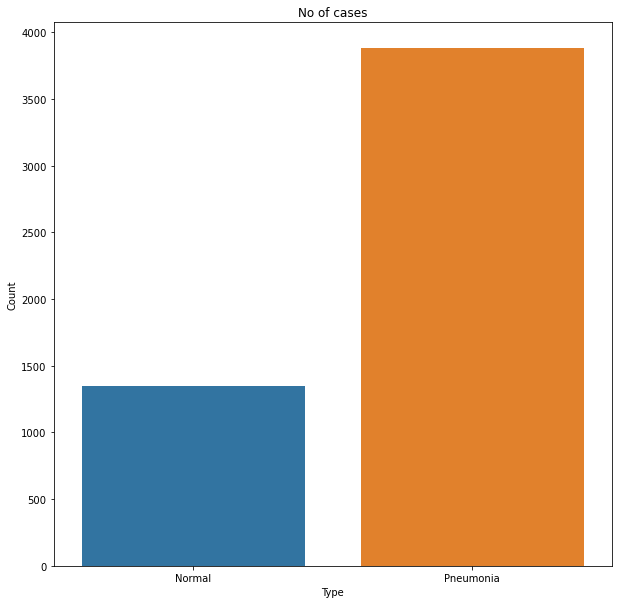

In [28]:
distribution = get_distribution(train_dataset, 'label')

### Correcting Imbalance

In [29]:
# we will try to correct this imbalance by assigning more weight to normal datasets than pneumonia ones
count_pnemonia = distribution[True]
count_normal = distribution[False]
count_total = len(train_dataset)
initial_bias = np.log([count_pnemonia/count_normal])
print('Initial bias = ', initial_bias)

Initial bias =  [1.05724447]


In [30]:
weight_for_normal = ((1 / count_normal)*count_total) / 2.0 
weight_for_pneumonia = ((1 / count_pnemonia)*count_total) / 2.0

class_weight = {False: weight_for_normal, True: weight_for_pneumonia}

print('Weight for class normal: {:.2f}'.format(weight_for_normal))
print('Weight for class pneumonia: {:.2f}'.format(weight_for_pneumonia))

Weight for class normal: 1.94
Weight for class pneumonia: 0.67


## Visualization

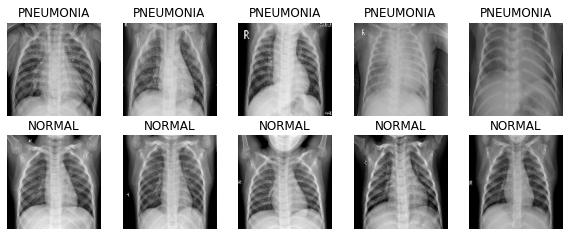

In [31]:
pneumonia_samples = (train_dataset[train_dataset['label']==True]['image'].iloc[:5]).tolist()
normal_samples = (train_dataset[train_dataset['label']==False]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
plt.figure(figsize=(10,10))
for n in range(10):
    img = parseImage(samples[n])
    ax = plt.subplot(5,5,n+1)
    plt.imshow(img)
    if n < 5:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")

## Building the model

In [32]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [33]:
def conv_layer(filters):
    block = tf.keras.Sequential([
        Conv2D(filters, (3,3), activation='relu', padding='same' ),
        Conv2D(filters, (3,3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D()
    ])
    
    return block
    
def dense_layer(units, dropout_rate):
    block = tf.keras.Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [34]:
vgg = VGG16(input_shape=RESIZE_IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

In [35]:
def build_vgg_model(base_model):
    model = Sequential([
        base_model,
        Flatten(),
        dense_layer(4096,0.5),
        dense_layer(4096, 0.5),
        dense_layer(1000, 0.5),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(lr=0.0001, decay=1e-5)
    es = EarlyStopping(patience=5)
    chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
    model.compile(loss='binary_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')], 
                  optimizer=optimizer)
    return model, es, chkpt
model, es, chkpt = build_vgg_model(vgg)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
sequential (Sequential)      (None, 4096)              33574912  
_________________________________________________________________
sequential_1 (Sequential)    (None, 4096)              16797696  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1000)              4101000   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 69,189,297
Trainable params: 54,456,225
Non-trainable params: 14,733,072
_________________________________

In [36]:
image_gen = ImageDataGenerator(
        rescale = 1/255,
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30, 
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip = False,
        vertical_flip=False
    )

test_gen = ImageDataGenerator(rescale = 1/255)

In [40]:
x_train = [parseImage(img) for img in train_dataset.iloc[:, 0].values]
print(len(x_train))

5232


In [41]:
# normalize
x_train = np.array(x_train) #/ 255 
x_train = x_train.reshape(-1, 150, 150, 3)
print(len(x_train), x_train.shape)
y_train = [label for label in train_dataset.iloc[:, 1].values]
# y_train = np.array(y_train) / 255 
print(len(y_train))
image_gen.fit(x_train)

5232 (5232, 150, 150, 3)
5232


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

In [43]:
x_test = [parseImage(img) for img in test_dataset.iloc[:, 0].values]

In [44]:
x_test = np.array(x_test) #/ 255 
x_test = x_test.reshape(-1, 150, 150, 3)
print(len(x_test), x_test.shape)
y_test = [label for label in test_dataset.iloc[:, 1].values]
# y_test = np.array(y_test) / 255 
print(len(y_test))
test_gen.fit(x_test) 

624 (624, 150, 150, 3)
624


### Fine tuning

In [58]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
no_train_steps = X_train.shape[0]//BATCH_SIZE

## Training

In [59]:
history = model.fit(image_gen.flow(X_train, Y_train, batch_size=BATCH_SIZE),   
                    epochs=EPOCHS, 
                    steps_per_epoch=no_train_steps,
                    validation_data=test_gen.flow(X_val, Y_val, batch_size=BATCH_SIZE),  
                    callbacks=[es, chkpt, lr_scheduler],
                    class_weight=class_weight)

Epoch 1/20
109/109 [==============================] - 312s 3s/step - loss: 0.3975 - accuracy: 0.8719 - precision: 0.9569 - recall: 0.8655 - val_loss: 0.3156 - val_accuracy: 0.8807 - val_precision: 0.9874 - val_recall: 0.8513 - lr: 0.0100
Epoch 2/20
109/109 [==============================] - 313s 3s/step - loss: 0.2931 - accuracy: 0.8986 - precision: 0.9636 - recall: 0.8967 - val_loss: 0.3377 - val_accuracy: 0.9166 - val_precision: 0.9906 - val_recall: 0.8970 - lr: 0.0089
Epoch 3/20
109/109 [==============================] - 307s 3s/step - loss: 0.2520 - accuracy: 0.9156 - precision: 0.9699 - recall: 0.9145 - val_loss: 0.2197 - val_accuracy: 0.9421 - val_precision: 0.9830 - val_recall: 0.9388 - lr: 0.0079
Epoch 4/20
109/109 [==============================] - 303s 3s/step - loss: 0.2228 - accuracy: 0.9110 - precision: 0.9696 - recall: 0.9080 - val_loss: 0.2884 - val_accuracy: 0.8952 - val_precision: 0.9920 - val_recall: 0.8668 - lr: 0.0071
Epoch 5/20
109/109 [============================

## Visualize performance

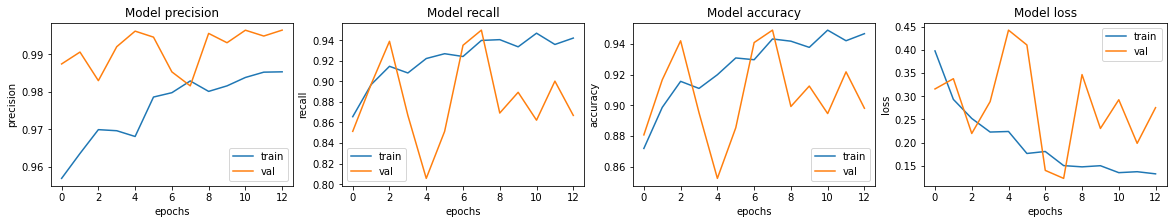

In [60]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Validate the model

In [78]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [74]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_gen.flow(x_test, y_test, batch_size=BATCH_SIZE), batch_size=BATCH_SIZE)


20/20 [==============================] - 32s 2s/step - loss: 0.1908 - accuracy: 0.9295 - precision: 0.9701 - recall: 0.9154


In [75]:
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_acc) 
print("Precision on test set: ", test_precision) 
print("Recall on test set: ", test_recall) 

Loss on test set:  0.19084049761295319
Accuracy on test set:  0.9294871687889099
Precision on test set:  0.970108687877655
Recall on test set:  0.9153845906257629


In [118]:
test_data = test_gen.flow(x_test, y_test, batch_size=BATCH_SIZE)

preds = model.predict(test_data)
y_pred = (preds > 0.5)[:,0]
y_actual = test_data.y

In [148]:
print('Labels ', y_actual[0:5])
print('Predicted ', y_pred[0:5])

Labels  [ True False  True False  True]
Predicted  [False  True False  True  True]


<Figure size 432x288 with 0 Axes>

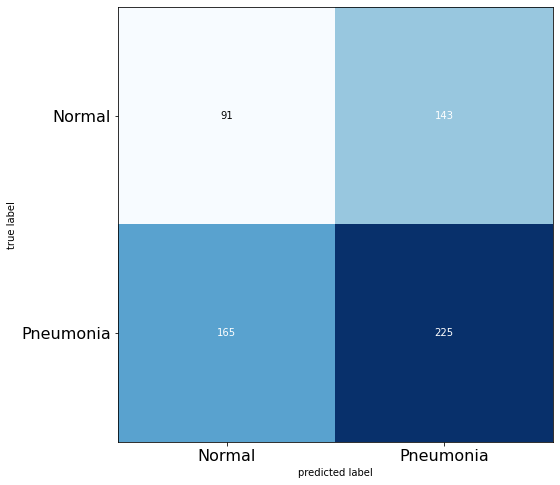

In [152]:
cm  = confusion_matrix(y_actual, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [154]:
model.save('model_preprocess_vgg16.h5')